# RECEPTOR

En este archivo lo primero es recibir el archivo correspondiente a la señal modulada 

In [1]:
# Importamos las librerias 
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt

In [5]:
# Importamos el archivo con la señal modulada 
data = np.load('Senial_OOK.npz')
t_moduladora = data['tiempo']
Senial_OOK = data['Amplitud']


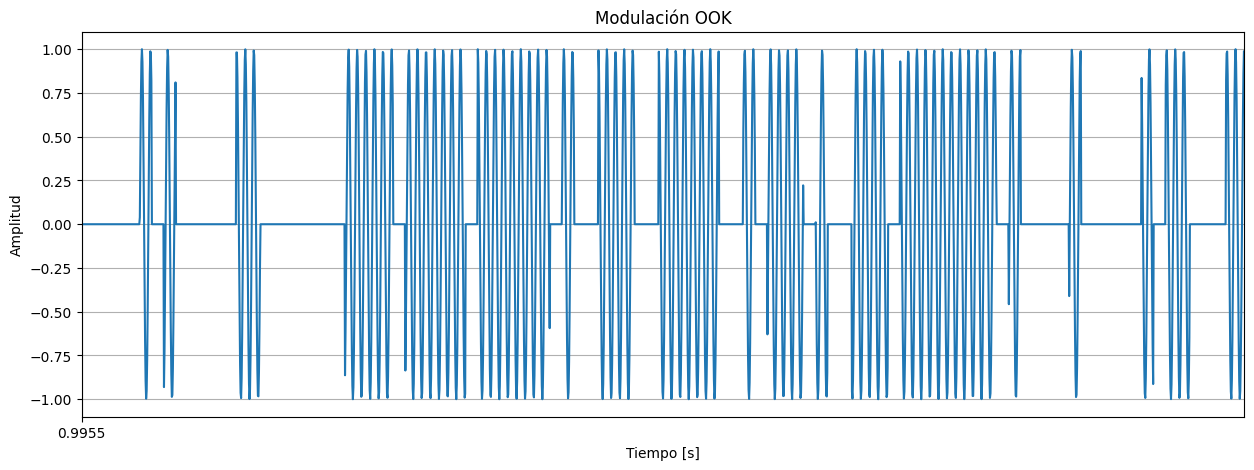

In [ ]:
#graficamos para verificar que se trata de la señal

plt.figure(figsize=(15,5))
plt.plot(t_moduladora, Senial_OOK)  # solo primeros 1000 puntos para visualizar bien
plt.grid(True)
plt.title("Modulación OOK")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.xlim(0.9955,1)
plt.xticks(np.arange(0.9955,1,0.1))
plt.show()

# Demodulacion
En la practica demodulariamos con un dectector de envolvente, que consta de rectificar la señal y filtrarla 

Se tratara de realizar lo mismo por software 

In [ ]:
# rectificamos la señal 
Senial_OOK_Rectificada = np.abs(Senial_OOK)

#filtramos (FPB)
